In [1]:
%load_ext watermark


In [2]:
from IPython.display import display
from matplotlib import colors as mpl_colors
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp

from pylib.munge._calc_fixprobs_from_traits import calc_fixprobs_from_traits
from pylib.viz._size_fixation_heatmap import size_fixation_heatmap


In [3]:
%watermark -diwmuv -iv


Last updated: 2024-10-13T19:07:58.935056+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

polars    : 1.9.0
seaborn   : 0.13.2
matplotlib: 3.9.2
pandas    : 2.2.3
teeplot   : 1.1.3

Watermark: 2.4.3



In [4]:
teeplot_subdir = "cupy-denovo-spatial1d-traits"
teeplot_subdir


'cupy-denovo-spatial1d-traits'

## Prep Data


In [5]:
dfpd = pd.read_parquet("https://osf.io/seuyf/download")
display(dfpd.describe()), display(dfpd.head()), display(dfpd.tail());


,trait count,trait cycle last seen,trait value,tile,row,col,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,nBen
count,1.984046e+07,1.984046e+07,19840464.0,1.984046e+07,1.984046e+07,1.984046e+07,1.984046e+07,19840464.0,19840464.0,19840464.0,19840464.0,19840464.0,1.984046e+07,1.984046e+07,19840464.0,1.984046e+07,19840464.0,19840464.0,1.984046e+07
mean,1.280000e+02,4.571166e+05,0.5,2.952400e+04,1.210000e+02,1.210000e+02,7.500000e+00,243.0,243.0,1.0,2.0,500000.0,1.648571e+02,1.648571e+02,256.0,1.100009e+00,0.0,0.0,1.850000e+01
std,1.279743e+02,1.342210e+05,0.5,1.704598e+04,7.014747e+01,7.014747e+01,4.031129e+00,0.0,0.0,0.0,0.0,0.0,1.063457e+02,1.063457e+02,0.0,0.000000e+00,0.0,0.0,1.055541e+01
min,0.000000e+00,1.630000e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,243.0,243.0,1.0,2.0,500000.0,1.000000e+00,1.000000e+00,256.0,1.100000e+00,0.0,0.0,2.000000e+00
25%,0.000000e+00,4.955160e+05,0.0,1.476200e+04,6.000000e+01,6.000000e+01,4.000000e+00,243.0,243.0,1.0,2.0,500000.0,2.700000e+01,2.700000e+01,256.0,1.100000e+00,0.0,0.0,1.150000e+01
50%,1.280000e+02,4.999990e+05,0.5,2.952400e+04,1.210000e+02,1.210000e+02,7.500000e+00,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,1.700000e+01
75%,2.560000e+02,4.999990e+05,1.0,4.428600e+04,1.820000e+02,1.820000e+02,1.100000e+01,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,2.500000e+01
max,2.560000e+02,4.999990e+05,1.0,5.904800e+04,2.420000e+02,2.420000e+02,1.400000e+01,243.0,243.0,1.0,2.0,500000.0,2.430000e+02,2.430000e+02,256.0,1.100000e+00,0.0,0.0,4.000000e+01


,trait count,trait cycle last seen,trait value,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,...,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,replicate,nBen
0,256,499999,0,0,0,0,genome_cupy_2xl_denovo_poisson,2,243,243,...,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2
1,0,497564,1,0,0,0,genome_cupy_2xl_denovo_poisson,2,243,243,...,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2
2,256,499999,0,1,1,0,genome_cupy_2xl_denovo_poisson,2,243,243,...,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2
3,0,496040,1,1,1,0,genome_cupy_2xl_denovo_poisson,2,243,243,...,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2
4,256,499999,0,2,2,0,genome_cupy_2xl_denovo_poisson,2,243,243,...,2,500000,3,3,256,1.1,0.0,0,6a21361c-25c3-416c-8747-c52e5b60b2e8,2


,trait count,trait cycle last seen,trait value,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,...,nTrait,nCycle,nColSubgrid,nRowSubgrid,tilePopSize,tournSize,msec,tsc,replicate,nBen
19840459,0,487961,1,59046,240,242,genome_cupy_28xl_denovo_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,43386019-7124-4a41-839a-40779573b1f0,28
19840460,256,499999,0,59047,241,242,genome_cupy_28xl_denovo_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,43386019-7124-4a41-839a-40779573b1f0,28
19840461,0,499815,1,59047,241,242,genome_cupy_28xl_denovo_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,43386019-7124-4a41-839a-40779573b1f0,28
19840462,256,499999,0,59048,242,242,genome_cupy_28xl_denovo_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,43386019-7124-4a41-839a-40779573b1f0,28
19840463,0,499830,1,59048,242,242,genome_cupy_28xl_denovo_poisson,14,243,243,...,2,500000,243,243,256,1.1,0.0,0,43386019-7124-4a41-839a-40779573b1f0,28


In [6]:
(apn,) = dfpd["tilePopSize"].unique()  # agents per node
apn


np.uint16(256)

In [7]:
dfxs = calc_fixprobs_from_traits(dfpd)
display(dfxs.describe()), display(dfxs.head()), display(dfxs.tail());


100%|██████████| 168/168 [00:00<00:00, 450.59it/s]


,group,trait value,replicate,population size,available beneficial mutations,fixation probability
count,1.594512e+06,1594512.0,1.594512e+06,1.594512e+06,1.594512e+06,1.594512e+06
mean,2.724031e+04,0.5,7.433498e+18,3.185400e+03,1.850000e+01,5.000000e-01
std,1.742655e+04,0.5,5.623792e+18,1.771294e+05,1.055541e+01,4.998772e-01
min,0.000000e+00,0.0,5.629117e+16,2.560000e+02,2.000000e+00,0.000000e+00
25%,1.181200e+04,0.0,1.832849e+18,2.560000e+02,1.150000e+01,0.000000e+00
50%,2.582950e+04,0.5,4.765690e+18,2.560000e+02,1.700000e+01,5.000000e-01
75%,4.243900e+04,1.0,1.172770e+19,2.560000e+02,2.500000e+01,1.000000e+00
max,5.904800e+04,1.0,1.842861e+19,1.511654e+07,4.000000e+01,1.000000e+00


,group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype
0,14120,1,16718381540940362211,2304,2,0.0,hypermutator
1,15626,0,16718381540940362211,2304,2,1.0,normomutator
2,987,1,16718381540940362211,2304,2,0.0,hypermutator
3,16332,1,16718381540940362211,2304,2,1.0,hypermutator
4,10744,0,16718381540940362211,2304,2,1.0,normomutator


,group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype
1594507,0,0,11296699210007709919,15116544,28,0.903000,normomutator
1594508,0,0,338636181003370639,15116544,28,0.893166,normomutator
1594509,0,1,338636181003370639,15116544,28,0.106834,hypermutator
1594510,0,0,12391793807524180926,15116544,28,0.975613,normomutator
1594511,0,1,12391793807524180926,15116544,28,0.024387,hypermutator


## Size Fixation Curves


teeplots/col=available-beneficial-mutations+errorbar=sd+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/col=available-beneficial-mutations+errorbar=sd+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


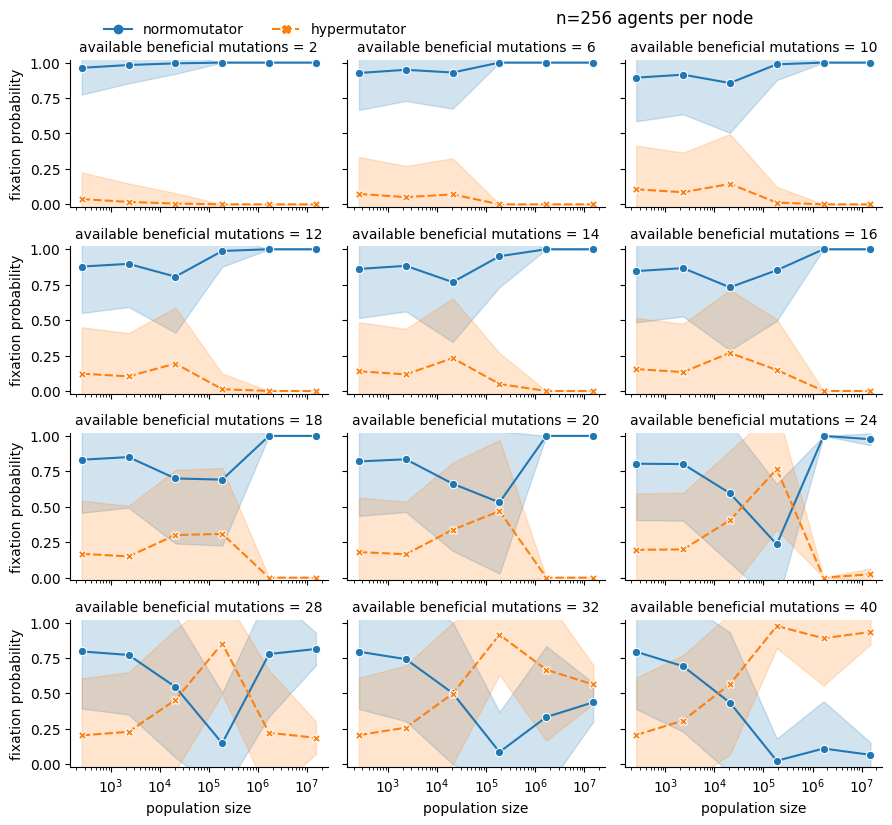

teeplots/col=available-beneficial-mutations+errorbar=se+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/col=available-beneficial-mutations+errorbar=se+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


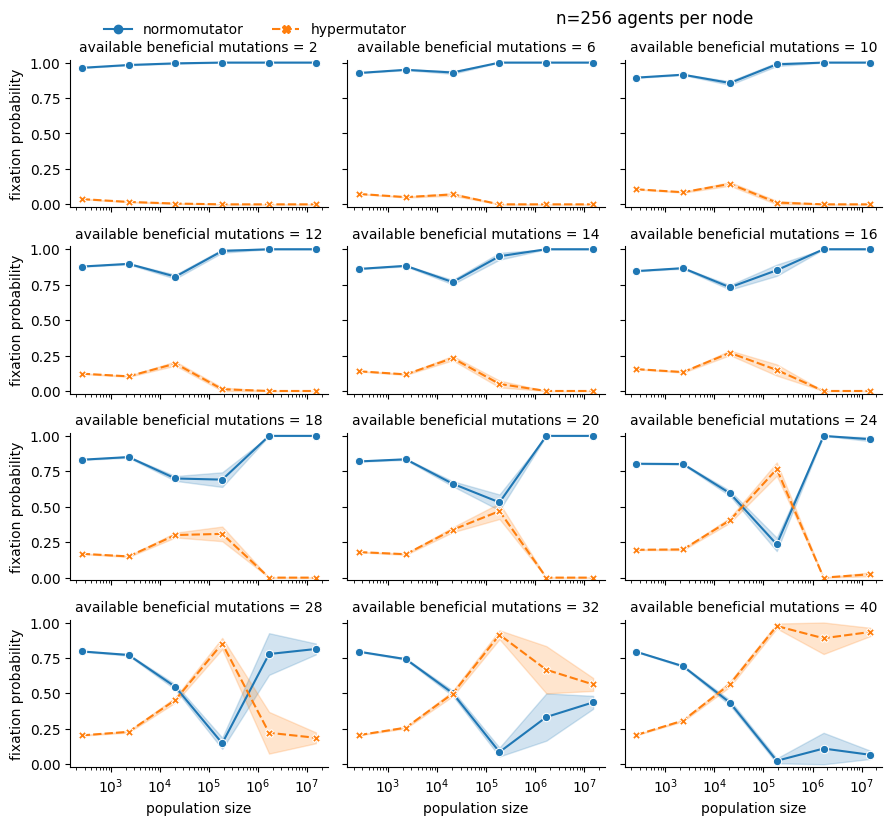

teeplots/col=available-beneficial-mutations+errorbar=ci+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/col=available-beneficial-mutations+errorbar=ci+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


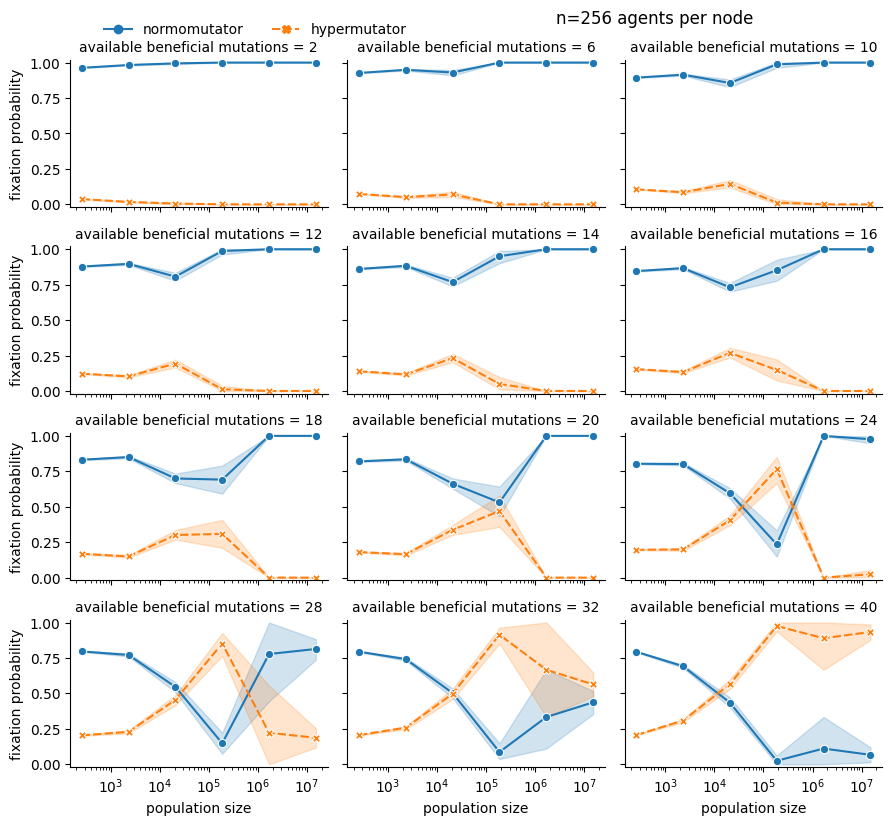

teeplots/col=available-beneficial-mutations+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/col=available-beneficial-mutations+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


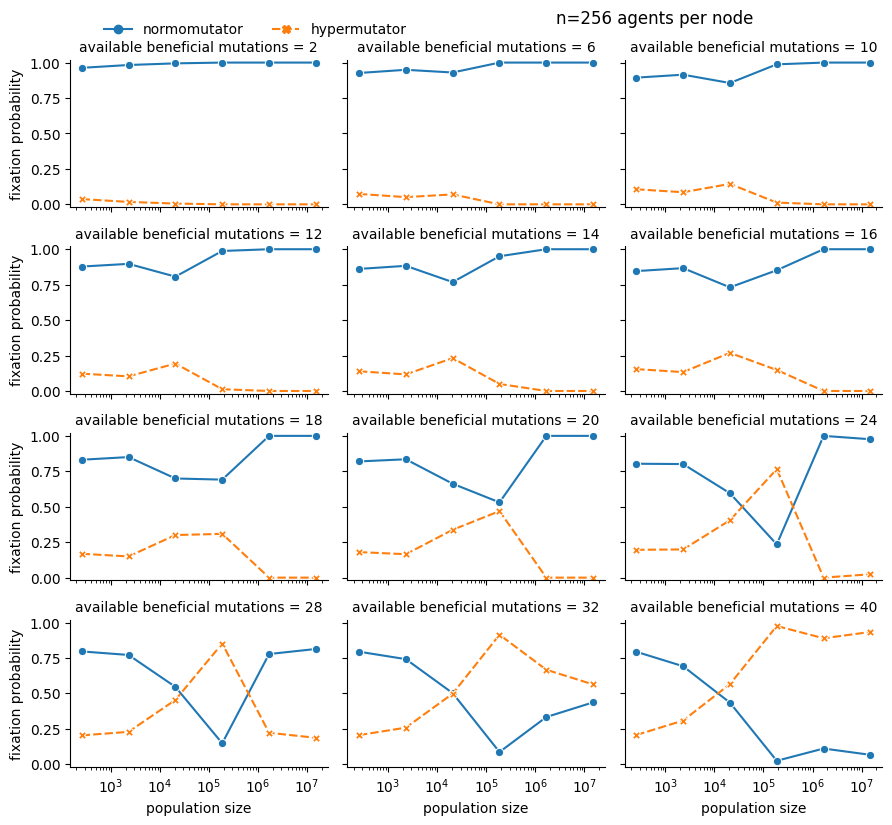

In [8]:
for errorbar in "sd", "se", "ci", None:
    tp.tee(
        sns.relplot,
        data=dfxs,
        x="population size",
        y="fixation probability",
        hue="genotype",
        col="available beneficial mutations",
        style="genotype",
        col_wrap=3,
        hue_order=["normomutator", "hypermutator"],
        style_order=["normomutator", "hypermutator"],
        aspect=1.5,
        height=2,
        kind="line",
        markers=True,
        teeplot_outexclude="post",
        errorbar=errorbar,
        teeplot_postprocess=f"""
teed.set(xscale="log", ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template="{{col_var}} = {{col_name:.0f}}")
sns.move_legend(
    teed,
    "lower center",
    bbox_to_anchor=(0.25, 0.97),
    frameon=False,
    ncol=2,
    title=None,
)
    """,
    )


teeplots/errorbar=sd+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/errorbar=sd+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


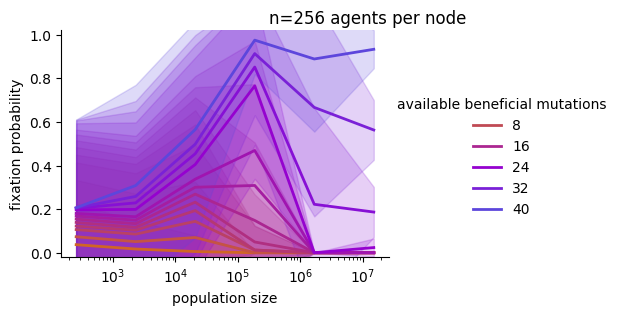

teeplots/errorbar=se+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/errorbar=se+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


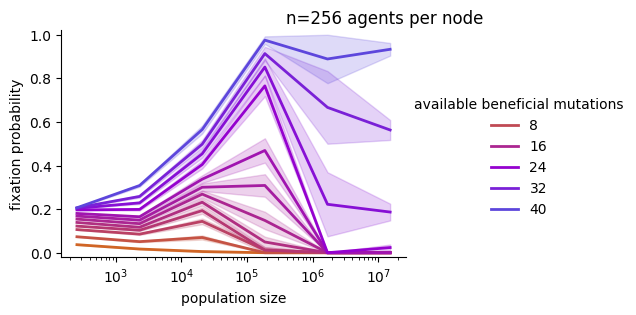

teeplots/errorbar=ci+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/errorbar=ci+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


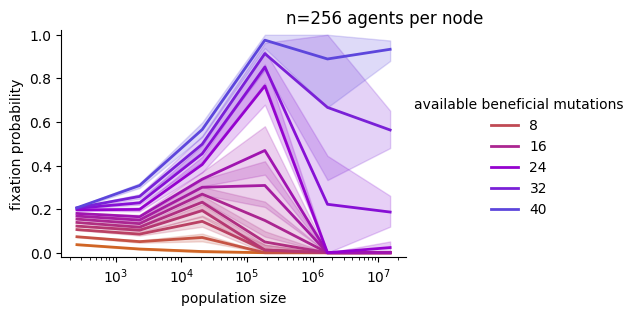

teeplots/hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


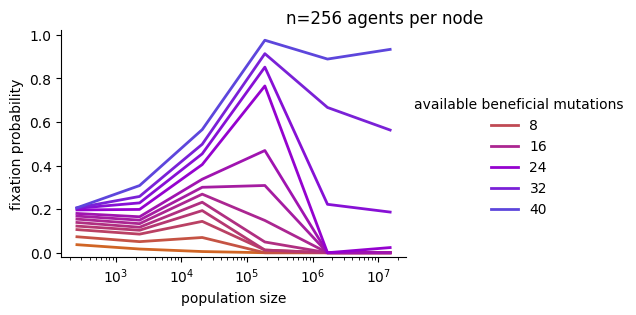

In [9]:
cmap = mpl_colors.LinearSegmentedColormap.from_list(
    "",
    ["chocolate", "darkviolet", "royalblue"],
)

for errorbar in "sd", "se", "ci", None:
    tp.tee(
        sns.relplot,
        data=dfxs[dfxs["genotype"] == "hypermutator"],
        x="population size",
        y="fixation probability",
        hue="available beneficial mutations",
        # style="available beneficial mutations",
        aspect=1.5,
        height=3,
        kind="line",
        markers=True,
        teeplot_outexclude="post",
        errorbar=errorbar,
        palette=cmap,
        linewidth=2,
        hue_norm=(1, 48),
        teeplot_postprocess=f"""
teed.set(xscale="log", ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
""",
    )


## Size Fixation Heatmap


teeplots/genotype=hypermutator+index=available-beneficial-mutations+on=population-size+values=fixation-probability+viz=size-fixation-heatmap+ext=.pdf
teeplots/genotype=hypermutator+index=available-beneficial-mutations+on=population-size+values=fixation-probability+viz=size-fixation-heatmap+ext=.png


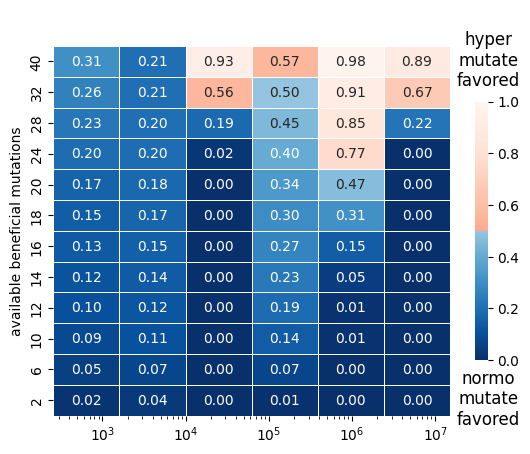

<Axes: ylabel='available beneficial mutations'>

In [10]:
tp.tee(
    size_fixation_heatmap,
    fixprobs_df=dfxs,
    genotype="hypermutator",
    index="available beneficial mutations",
    on="population size",
    values="fixation probability",
)


## Quality Check: Number Replicates Available


In [11]:
categories = (
    pl.DataFrame(dfxs)
    .group_by(
        "population size",
    )
    .first()["population size"]
    .sort()
    .cast(pl.String)
    .to_list()
)
categories


['256', '2304', '20736', '186624', '1679616', '15116544']

In [12]:
dfy = pl.DataFrame(dfxs).with_columns(
    pl.col("population size")
    .cast(pl.String)
    .cast(pl.Enum(categories))
    .alias("population size cat"),
)
display(dfy.describe()), display(dfy.head()), display(dfy.tail());


statistic,group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,population size cat
str,f64,f64,f64,f64,f64,f64,str,str
"""count""",1.594512e6,1.594512e6,1.594512e6,1.594512e6,1.594512e6,1.594512e6,"""1594512""","""1594512"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0"""
"""mean""",27240.309401,0.5,7.4335e18,3185.400163,18.5,0.5,null,null
"""std""",17426.548245,0.5,5.6238e18,177129.356354,10.555413,0.499877,null,null
"""min""",0.0,0.0,5.6291e16,256.0,2.0,0.0,null,null
"""25%""",11812.0,0.0,1.8328e18,256.0,12.0,0.0,null,null
"""50%""",25830.0,1.0,4.7657e18,256.0,18.0,0.515625,null,null
"""75%""",42439.0,1.0,1.1728e19,256.0,24.0,1.0,null,null
"""max""",59048.0,1.0,1.8429e19,1.5116544e7,40.0,1.0,null,null


group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,population size cat
u32,u8,u64,u64,i8,f64,cat,enum
14120,1,16718381540940362211,2304,2,0.0,"""hypermutator""","""2304"""
15626,0,16718381540940362211,2304,2,1.0,"""normomutator""","""2304"""
987,1,16718381540940362211,2304,2,0.0,"""hypermutator""","""2304"""
16332,1,16718381540940362211,2304,2,1.0,"""hypermutator""","""2304"""
10744,0,16718381540940362211,2304,2,1.0,"""normomutator""","""2304"""


group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,population size cat
u32,u8,u64,u64,i8,f64,cat,enum
0,0,11296699210007709919,15116544,28,0.903,"""normomutator""","""15116544"""
0,0,338636181003370639,15116544,28,0.893166,"""normomutator""","""15116544"""
0,1,338636181003370639,15116544,28,0.106834,"""hypermutator""","""15116544"""
0,0,12391793807524180926,15116544,28,0.975613,"""normomutator""","""15116544"""
0,1,12391793807524180926,15116544,28,0.024387,"""hypermutator""","""15116544"""


teeplots/cupy-denovo-spatial1d-traits/col=available-beneficial-mutations+hue=genotype+kind=hist+multiple=dodge+viz=displot+x=population-size-cat+ext=.pdf
teeplots/cupy-denovo-spatial1d-traits/col=available-beneficial-mutations+hue=genotype+kind=hist+multiple=dodge+viz=displot+x=population-size-cat+ext=.png


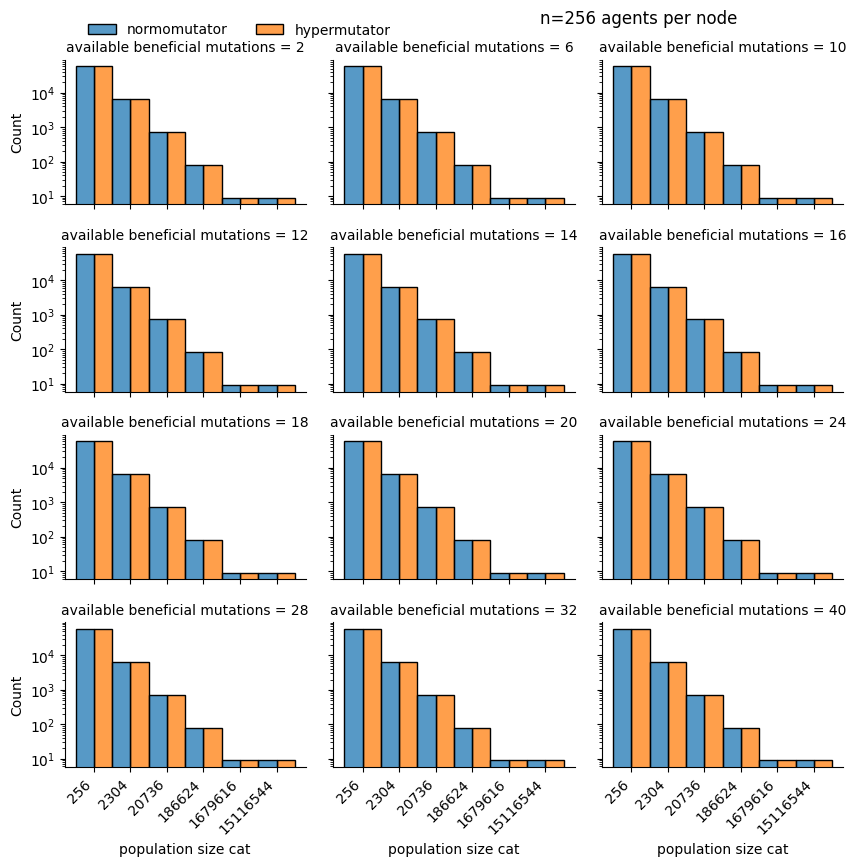

In [13]:
tp.tee(
    sns.displot,
    data=dfy.to_pandas(),
    x="population size cat",
    hue="genotype",
    col="available beneficial mutations",
    col_wrap=3,
    hue_order=["normomutator", "hypermutator"],
    aspect=1.5,
    height=2,
    kind="hist",
    multiple="dodge",
    teeplot_subdir=teeplot_subdir,
    teeplot_outexclude="post",
    teeplot_postprocess=f"""
teed.set(yscale='log')
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
for ax in teed.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
sns.move_legend(
    teed, "lower center",
    bbox_to_anchor=(0.25, 0.97),
    frameon=False,
    ncol=2,
    title=None,
)
""",
)


## Quality Check: Has Reached Fixation?


In [14]:
dfxs_ = dfxs[dfxs["genotype"] == "hypermutator"].copy().reset_index(drop=True)


In [15]:
dfxs_["unfixed"] = (dfxs_["fixation probability"] != 1.0) & (
    dfxs_["fixation probability"] > 0.001
)


teeplots/cupy-denovo-spatial1d-traits/col=available-beneficial-mutations+hue=genotype+kind=scatter+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-denovo-spatial1d-traits/col=available-beneficial-mutations+hue=genotype+kind=scatter+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


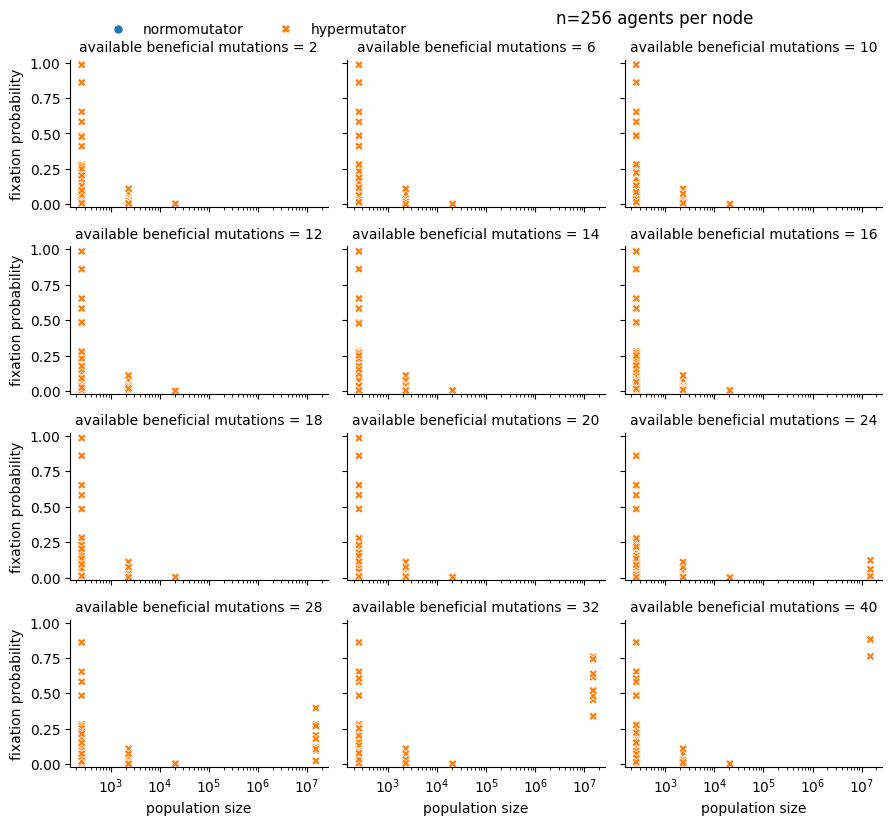

In [16]:
tp.tee(
    sns.relplot,
    data=dfxs_[dfxs_["unfixed"]],
    x="population size",
    y="fixation probability",
    hue="genotype",
    col="available beneficial mutations",
    style="genotype",
    col_wrap=3,
    hue_order=["normomutator", "hypermutator"],
    style_order=["normomutator", "hypermutator"],
    aspect=1.5,
    height=2,
    kind="scatter",
    markers=True,
    teeplot_outexclude="post",
    teeplot_subdir=teeplot_subdir,
    teeplot_postprocess=f"""
teed.set(xscale='log', ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
sns.move_legend(
teed,
"lower center",
bbox_to_anchor=(0.25, 0.97),
frameon=False,
ncol=2,
title=None,
)
""",
)


teeplots/cupy-denovo-spatial1d-traits/col=available-beneficial-mutations+hue=unfixed+multiple=fill+viz=displot+x=population-size+ext=.pdf
teeplots/cupy-denovo-spatial1d-traits/col=available-beneficial-mutations+hue=unfixed+multiple=fill+viz=displot+x=population-size+ext=.png


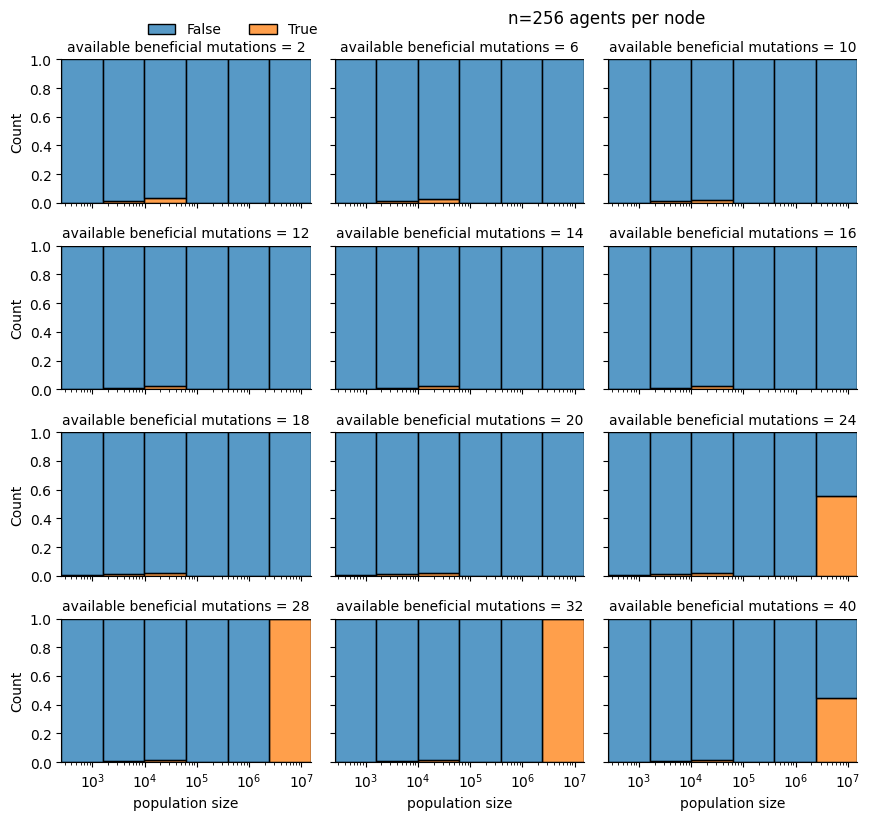

In [17]:
tp.tee(
    sns.displot,
    data=dfxs_.reset_index(drop=True),
    x="population size",
    hue="unfixed",
    col="available beneficial mutations",
    col_wrap=3,
    aspect=1.5,
    height=2,
    multiple="fill",
    bins=dfxs_["population size"].nunique(),
    log_scale=(True, False),
    teeplot_outexclude="post",
    teeplot_subdir=teeplot_subdir,
    teeplot_postprocess=f"""
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
sns.move_legend(
teed,
"lower center",
bbox_to_anchor=(0.25, 0.97),
frameon=False,
ncol=2,
title=None,
)
""",
)
